## Module 2
# SVM Classification: Song Emotions 

In [2]:
%matplotlib inline

import os,sys,inspect

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)

import pandas as pd
import numpy as np
import seaborn as sns

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix


import plotly.express as px
import matplotlib.pyplot as plt
from fma_metadata import utils

import warnings
warnings.filterwarnings('ignore')

##### Function for plotting confusion matrix

In [100]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

##### Function for plotting roc curve

In [84]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

### Data Preprocessing

In [3]:
# read data: features
data = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/features.csv')

# read labels: song_happiness
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_happiness_labels.csv')
label= labels.set_index('track_id')

# merge labels with data
data = data.merge(labels, on='track_id')

# remove duplicate rows
data.drop_duplicates(keep=False, inplace=True)
# remove Null values (if there are)
data.dropna()

# reset index to track_id
data = data.set_index('track_id')
data.rename({'valence': 'song_emotion'}, axis='columns', inplace=True)
# view data
data.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",song_emotion
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,happy
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,sad
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,happy
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,happy
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,happy


In [4]:
# check number of records per class
data.song_emotion.value_counts()

sad      7724
happy    5405
Name: song_emotion, dtype: int64

In [5]:
# encoding labels
le = preprocessing.LabelEncoder()
data['song_emotion'] = le.fit_transform(data['song_emotion'])
data.song_emotion.value_counts()

1    7724
0    5405
Name: song_emotion, dtype: int64

In [6]:
# remove labels from dataset 
labels = data[['song_emotion']]
data.drop('song_emotion', axis=1, inplace=True)


In [7]:
# split data in traning and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42, stratify=labels,
                                                   shuffle=True) 

In [8]:
# normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
le.inverse_transform(y_train)

array(['sad', 'happy', 'sad', ..., 'sad', 'sad', 'sad'], dtype=object)

#### Visualize data in 2D with  PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(2,random_state=42)
pca.fit(X_train)
pca_proj = pca.transform(X_train)

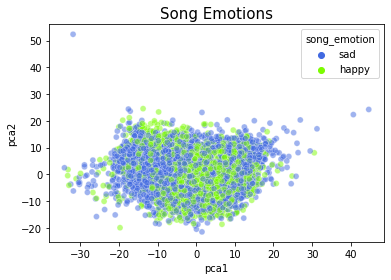

In [11]:
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['song_emotion'] = le.inverse_transform(y_train)
# plot scatter of PCA
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='song_emotion',
    palette={'happy':'lawngreen','sad':'royalblue'},
    data=df,
    c='black',
    legend="full",
    alpha=0.5
)
plt.title("Song Emotions", fontsize= 15)
plt.show()

In [12]:
# make sure data are np.ndarray
y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SVM Classifier
#### Import modules

In [13]:
from sklearn.svm import SVC, LinearSVC
import random
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### SVM: Hard Margin (linear)

In [32]:
#help(LinearSVC)

In [31]:
lsvm = LinearSVC(C= 0.6, class_weight='balanced', verbose=1, random_state=42)
lsvm.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=0.6, class_weight='balanced', random_state=42, verbose=1)

In [34]:
prediction_lsvm = lsvm.predict(X_test)
print(classification_report(y_test,prediction_lsvm ))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1622
           1       0.81      0.74      0.77      2317

    accuracy                           0.75      3939
   macro avg       0.74      0.75      0.74      3939
weighted avg       0.75      0.75      0.75      3939



In [ ]:
#help(GridSearchCV)

In [41]:
# Random search for C parameter in Linear SVM

params = {
    'C': [0.2, 0.5, 1, 10, 20,40, 50, 100, 300],
}

# coarse grid search
model = LinearSVC(class_weight='balanced', verbose=1, random_state=42)

gs = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, return_train_score=True, verbose=True)
gs_result = gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.1min finished


[LibLinear]

In [45]:
print(f"best parameters:\n{gs_result.best_params_}\naccuracy: {gs_result.best_score_}")


best parameters:
{'C': 0.5}
accuracy: 0.7405871036632231


In [49]:
# Fine Random search for C parameter in Linear SVM

params = {
    'C': [random.uniform(0.4,0.8)],
}

# coarse grid search
model = LinearSVC(class_weight='balanced', verbose=1, random_state=42)

gs = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, n_iter= 10,verbose=True)
gs_result = gs.fit(X_train, y_train)
print(f"best parameters:\n{gs_result.best_params_}\naccuracy: {gs_result.best_score_}")

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.9min finished


[LibLinear]best parameters:
{'C': 0.7849983134956344}
accuracy: 0.7429769660265773


##### First gird best model
{'C': 0.6455675716083595}
accuracy: 0.7324256326456853

##### Second grid best model
{'C': 0.43297022231553295}
accuracy: 0.7461356520132069

##### Third gird best model
{'C': 0.7849983134956344}
accuracy: 0.7429769660265773

### Retrain and test the model

In [86]:
lsvm = LinearSVC(C= 0.43297022231553295, class_weight='balanced', verbose=1, random_state=42)
lsvm.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=0.43297022231553295, class_weight='balanced', random_state=42,
          verbose=1)

In [87]:
prediction_lsvm = lsvm.predict(X_test)
print(classification_report(y_test,prediction_lsvm ))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1622
           1       0.83      0.75      0.79      2317

    accuracy                           0.76      3939
   macro avg       0.76      0.76      0.76      3939
weighted avg       0.77      0.76      0.76      3939



SVM with Soft Margin returned an accuracy of 76%.<br>
The recall is high for both classes, meaning that the model is able to distinguish between sad and happy songs. However the precision of Happy songs is lower than the one for sad songs (68% and 83& respectively).<br>
Clearly the model predicted as happy 30% of tracks which were actually sad. <br> Since we chose this task to be binary and considering that there are several emotions that range from sadness to happiness, it is clearly understandable that some track might be just in between, and therefore might be misclassified by our model.

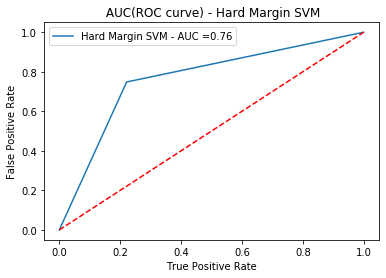

In [106]:
plot_roc_curve(y_test, prediction_lsvm, 'Hard Margin SVM')

In [104]:
cf_matrix = confusion_matrix(y_test, prediction_lsvm)
cf_matrix

array([[1263,  359],
       [ 583, 1734]])

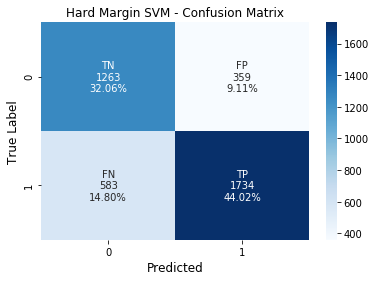

In [105]:
make_confusion_matrix(cf_matrix, 'Hard Margin SVM - Confusion Matrix')

In [91]:
decision_function = lsvm.decision_function(X_train)
print(decision_function)

[-0.19761608 -0.56544166  1.47989113 ...  0.82443863 -0.24166548
  0.16644151]


In [92]:
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vector_indices

array([   0,    1,    4, ..., 9187, 9188, 9189])

In [93]:
support_vector_indices.shape, X_train.shape

((7429,), (9190, 518))

### SVM: Soft Margin

In [45]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

##### kernel: rbf

In [43]:
svm = SVC(kernel = 'rbf', random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [44]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1622
           1       0.79      0.83      0.81      2317

    accuracy                           0.77      3939
   macro avg       0.76      0.76      0.76      3939
weighted avg       0.77      0.77      0.77      3939



##### kernel: poly

In [46]:
svm = SVC(kernel = 'poly', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='poly', random_state=42)

In [47]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.72      0.45      0.56      1622
           1       0.70      0.87      0.78      2317

    accuracy                           0.70      3939
   macro avg       0.71      0.66      0.67      3939
weighted avg       0.70      0.70      0.69      3939



##### kernel: linear

In [50]:
svm = SVC(kernel = 'linear', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [51]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1622
           1       0.79      0.80      0.79      2317

    accuracy                           0.75      3939
   macro avg       0.75      0.74      0.75      3939
weighted avg       0.75      0.75      0.75      3939



### Grid Search coarse

In [14]:
# Coarse grid search for C parameter in SVM - soft margin
params = {
    'C': [0.2, 0.4, 0.7, 3, 10, 20, 40, 100],
    'kernel':['rbf', 'linear', 'sigmoid']
}

# coarse grid search
model_coarse = SVC(verbose=1, random_state=42)

gs_coarse = GridSearchCV(estimator=model_coarse, param_grid=params, cv=3, return_train_score=True, verbose=True)
gs_result = gs_coarse.fit(X_train, y_train)

print(f"best parameters:\n{gs_result.best_params_}\naccuracy: {gs_result.best_score_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 1071.3min finished


[LibSVM]best parameters:
{'C': 3, 'kernel': 'rbf'}
accuracy: 0.7605000885097319


### Fine Random Search 

In [16]:
# Fine Random search for C parameter in SVM - soft margin
params = {
    'C': [random.uniform(1, 5)],
    'kernel':['rbf']
}

# coarse grid search
model_coarse = SVC(verbose=1, random_state=42)

gs_coarse = RandomizedSearchCV(estimator=model_coarse, param_distributions=params, cv=3, n_iter= 20,verbose=True)
gs_result = gs_coarse.fit(X_train, y_train)

print(f"best parameters:\n{gs_result.best_params_}\naccuracy: {gs_result.best_score_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


[LibSVM]best parameters:
{'kernel': 'rbf', 'C': 1.419617535998578}
accuracy: 0.7634383132630767


###### best results:
- {'kernel': 'rbf', 'C': 1.8029951438363414} accuracy: 0.7634379936051364
- kernel': 'rbf', 'C': 1.419617535998578} accuracy: 0.7634383132630767

## Retrain Model 

In [94]:
svm = SVC(kernel = 'rbf', C=1.419617535998578, random_state=42)
svm.fit(X_train, y_train)

SVC(C=1.419617535998578, random_state=42)

#### Predict

In [95]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1622
           1       0.80      0.82      0.81      2317

    accuracy                           0.77      3939
   macro avg       0.77      0.76      0.76      3939
weighted avg       0.77      0.77      0.77      3939



In [102]:
cf_matrix_soft = confusion_matrix(y_test, pred_svm)
cf_matrix_soft

array([[1136,  486],
       [ 406, 1911]])

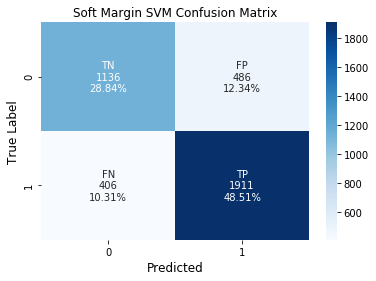

In [101]:
make_confusion_matrix(cf_matrix_soft, 'Soft Margin SVM Confusion Matrix')

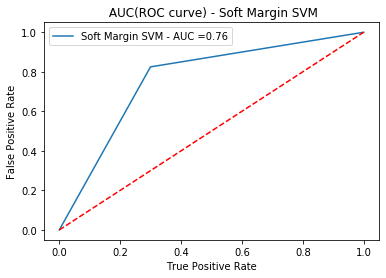

In [107]:
plot_roc_curve(y_test, pred_svm, 'Soft Margin SVM')

#### Conclusions

SVM with Hard Margin and SVM with Soft Margin have similar performance. <br> Both have an AUC score of 0.76 (which is considered a good result).<br>
The models are able to distinguish well tracks based on the emotions associated with them. <br> 
We noticed that LinearSVM had an higher TN rate (meaning it performed better than SVM with Hard Margin in recognizing class "Happy") compared to NonLinear SVM. On the other hand the latter, has an higher True Positive Rate ( 48.51% and 44.02% respectively).
<br><br>
We also noticed that high value of the hyperparameter C negatively affected the performance of the model. A good range resulted 1- 3, whith the optimal configuration be approximately 1.41.